In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os

%load_ext tensorboard

_include_('curriculum_vqa')
_include_('commons')

data_bin = f'{DEV_HOME}/curriculum_vqa/data-bin'

In [3]:
from cvqa import datasets, models, trainers, viz

In [4]:
# curriculum_root = f'{data_bin}/basic_curriculum'
curriculum_root = f'{data_bin}/curriculum_1'

train_dataset = datasets.Curriculum(curriculum_root, 'train', limit=100)
vocab = train_dataset.vocab
dev_dataset = train_dataset # datasets.Curriculum(curriculum_root, 'dev', vocab=vocab, limit=10)
train_dataset

Root: /Users/urisherman/Work/workspace/curriculum_vqa/data-bin/curriculum_1/train 
Samples: 100 (N_prompt=11, N_target=1)
Concepts: 0 
Classes: 0 
Vocab Tokens:50

In [5]:
train_dataset.use_viz_rep = True

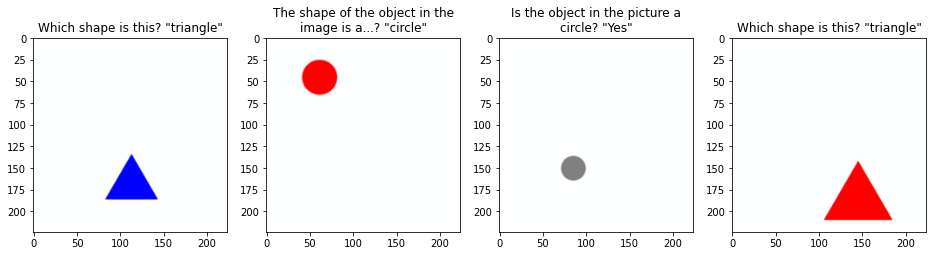

In [6]:
viz.show_samples(train_dataset)

In [9]:
import numpy as np
import torch
import torch.nn as nn
import torchvision as tv
from cvqa import fairseq_misc

seed = 1
np.random.seed(seed)
torch.manual_seed(seed)

vocab = train_dataset.vocab

def build_model(
    d=128,
    img_output_features=4,
    encoder_ffn_dim=256,
    encoder_layers=2,
    encoder_attention_heads=2,
    decoder_ffn_dim=256,
    decoder_layers=2,
    decoder_attention_heads=2):

    tokens_embed = fairseq_misc.build_embedding(vocab, d)
    encoder = fairseq_misc.build_vqa_encoder(
        vocab, tokens_embed,
        ffn_dim=encoder_ffn_dim,
        layers=encoder_layers,
        attention_heads = encoder_attention_heads
    )
    decoder = fairseq_misc.build_decoder(
        vocab, tokens_embed,
        ffn_dim=decoder_ffn_dim,
        layers=decoder_layers,
        attention_heads=decoder_attention_heads
    )

    struct_viz=True
    if struct_viz:
        img_perceptor = models.StructuredImageModel(
          train_dataset.struct_viz_vocab, d, img_output_features)
    else:
        img_perceptor = models.BasicImgModel(d, img_output_features)
    
    return models.VQAModelV1(encoder, img_perceptor, decoder, bos=vocab.bos_index)
    

trainer = trainers.VQATrainer(progressbar='epochs')

def train_model(model, lr=1e-4, epochs=10, batch_size=32):
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_loss, train_acc, dev_acc = trainer.train(
        model, train_dataset, dev_dataset, 
        optimizer, num_epochs=epochs, batch_size=batch_size
    )
    return {
        'train_loss': train_loss, 
        'train_acc': train_acc, 
        'dev_acc': dev_acc
    }

In [12]:
from cvqa.experiments import Experiments


exp = Experiments(build_model, train_model)

exp.execute({
    'd': [16, 32, 64, 128],
    'img_output_features': np.arange(2, 7),
    'encoder_ffn_dim': [16, 32, 64, 128],
    'encoder_layers': np.arange(1, 4),
    'encoder_attention_heads': np.arange(1, 4),
    'decoder_ffn_dim': [16, 32, 64, 128],
    'decoder_layers': np.arange(1, 4),
    'decoder_attention_heads': np.arange(1, 4),
    'epochs': [20]
}, limit=100)

[epoch=19, steps=611, train_acc=0.00, dev_acc=0.00] loss: 4.426: 100%|██████████| 20/20 [00:01<00:00, 15.86it/s]
[epoch=19, steps=611, train_acc=0.00, dev_acc=0.00] loss: 4.251: 100%|██████████| 20/20 [00:01<00:00, 16.07it/s]
[epoch=19, steps=611, train_acc=0.01, dev_acc=0.01] loss: 4.203: 100%|██████████| 20/20 [00:01<00:00, 13.01it/s]
[epoch=19, steps=611, train_acc=0.04, dev_acc=0.04] loss: 4.014: 100%|██████████| 20/20 [00:01<00:00, 12.62it/s]
[epoch=19, steps=611, train_acc=0.08, dev_acc=0.08] loss: 4.557: 100%|██████████| 20/20 [00:01<00:00, 10.81it/s]
[epoch=19, steps=611, train_acc=0.15, dev_acc=0.15] loss: 4.373: 100%|██████████| 20/20 [00:01<00:00, 10.66it/s]
[epoch=19, steps=611, train_acc=0.05, dev_acc=0.05] loss: 4.255: 100%|██████████| 20/20 [00:01<00:00, 16.19it/s]
[epoch=19, steps=611, train_acc=0.00, dev_acc=0.00] loss: 4.343: 100%|██████████| 20/20 [00:01<00:00, 16.00it/s]
[epoch=19, steps=611, train_acc=0.00, dev_acc=0.00] loss: 4.623: 100%|██████████| 20/20 [00:01<0

In [21]:
import json

files = list(Path(exp.log_root).glob('results.*'))

results = []
for fpath in files:
    with open(fpath) as f:
        for line in f:
            results.append(json.loads(line)) 
            
results

[{'id': 61,
  'hyper_parameters': {'d': 16,
   'img_output_features': 2,
   'encoder_ffn_dim': 16,
   'encoder_layers': 1,
   'encoder_attention_heads': 2,
   'decoder_ffn_dim': 64,
   'decoder_layers': 3,
   'decoder_attention_heads': 2,
   'epochs': 20},
  'train_metrics': {'train_loss': [4.605345249176025,
    4.624070644378662,
    4.550556659698486,
    5.132396697998047,
    4.780184745788574,
    4.5383830070495605,
    4.602725028991699,
    5.07012939453125,
    4.458172798156738,
    4.843066692352295,
    4.576494216918945,
    3.9163925647735596,
    4.420322418212891,
    4.53147029876709,
    4.681002616882324,
    4.326810836791992,
    4.7028374671936035,
    4.398416996002197,
    4.37775182723999,
    4.237116813659668,
    4.552854537963867,
    4.311010837554932,
    4.52213716506958,
    4.773022174835205,
    4.233861446380615,
    4.295727729797363,
    4.401895999908447,
    4.406059265136719,
    4.209525108337402,
    4.460972309112549,
    4.104813575744629,


In [13]:
def read_experiments_log(log_root):
    file_paths = Path(log_root).glob('results.*')
    metric_files = [f for f in file_paths if metric_name in ntpath.basename(f)]
    
    ret = pd.DataFrame()
    
    for f in metric_files:
        data = pd.read_json(f, lines=True)
        ret = ret.append(data, ignore_index = True)
    
    return ret.sort_values(by=ret.columns[0])

'experiments/run--09-24--18-39-27'

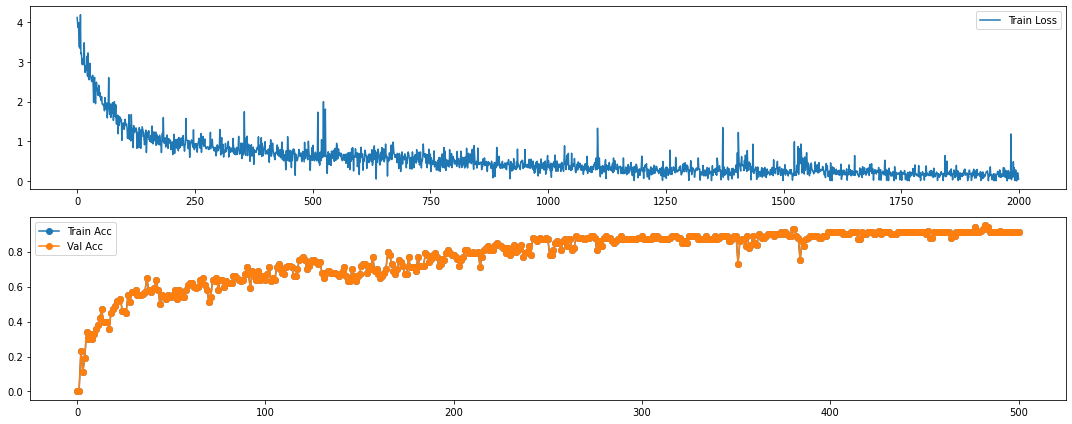

In [123]:
viz.plot_training(train_loss, train_acc, dev_acc)

Sample index: 50
Prompt: This is a red object.
Decoded encoded prompt: This is a red object. <pad> <pad> <pad> <pad> <pad>
True: False
Pred: False
* Encoded Structured Img Rep: tensor([6, 7])


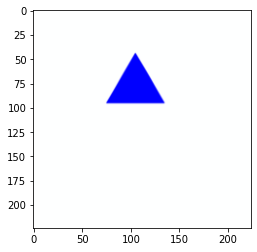

In [102]:
viz.test_natural_sample(model, train_dataset)

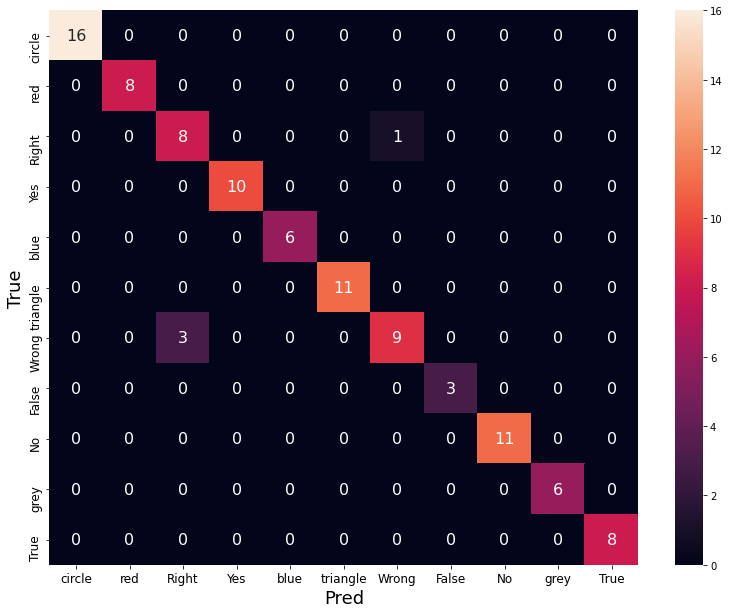

In [89]:
y_true, y_pred = trainer.get_predictions(model, train_dataset)
viz.one_word_conf_mat(y_true, y_pred, train_dataset.vocab)